### Load models

In [1]:
from app.model import *
from app.utils import *

/home/koala/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- Transformer with general attention

In [37]:
generalTransformer = initialize_model('general_attention')
generalTransformer.load_state_dict(torch.load('./models/general_attention.pt',map_location=torch.device('cpu')))


<All keys matched successfully>

- Transformer with multiplicative attention

In [38]:
multiplicativeTransformer = initialize_model('multiplicative_attention')
multiplicativeTransformer.load_state_dict(torch.load('./models/multiplicative_attention.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

- Transformer with additive attention

In [39]:
additiveTransformer = initialize_model('additive_attention')
additiveTransformer.load_state_dict(torch.load('./models/additive_attention.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

### Test with random sentences

In [40]:
def translate_sentence(model, sentence, max_len=50):
    model.eval()
    
    # Tokenize the source sentence if it's not already tokenized
    if isinstance(sentence, str):
        tokens = [token.lower() for token in token_transform[SRC_LANGUAGE](sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    
    # Numericalize the tokens using the vocabulary
    tokens = [SOS_IDX] + [vocab_transform[SRC_LANGUAGE].get_stoi()[token] 
                          if token in vocab_transform[SRC_LANGUAGE].get_stoi() else UNK_IDX for token in tokens] + [EOS_IDX]
    src_indexes = torch.LongTensor(tokens).to(device)
    src_indexes = src_indexes.reshape(1,-1)
    
    # Create a source mask
    src_mask = model.make_src_mask(src_indexes)
    
    with torch.no_grad():
        enc_src = model.encoder(src_indexes, src_mask)
    
    trg_indexes = [SOS_IDX]
    
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        
        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:, -1].item()
        trg_indexes.append(pred_token)
        
        if pred_token == EOS_IDX:
            break
    
    trg_tokens = [vocab_transform[TRG_LANGUAGE].get_itos()[i] for i in trg_indexes]
    
    return trg_tokens, attention  

In [41]:
english_sentence_1 = 'who are they'

myanmar_sentence_1_gen, general_attention_map = translate_sentence(generalTransformer, english_sentence_1 ,max_len=100)
print('trnsformer_with_gnrl_attention: ', myanmar_sentence_1_gen)# Remove <sos> and <eos> tokens before returning
myanmar_sentence_1_multi, multiplicative_attention_map = translate_sentence(multiplicativeTransformer, english_sentence_1, max_len=100)
print('transformer_with_multi_attention: ', myanmar_sentence_1_multi)
myanmar_sentence_1_add, additive_attention_map = translate_sentence(additiveTransformer, english_sentence_1,max_len=100)
print('transformer_with_add_attention: ', myanmar_sentence_1_add)

trnsformer_with_gnrl_attention:  ['<sos>', 'ဒီ', 'နေ့', 'က', 'အိမ်', 'မှာ', 'ပါ', '။', '<eos>']
transformer_with_multi_attention:  ['<sos>', 'ကျွန်တော်', 'ဒီ', 'နေ့', 'တိုင်း', 'စား', 'တယ်', '။', '<eos>']
transformer_with_add_attention:  ['<sos>', 'မစ္စ', 'တာ', 'ခိ', 'မု', 'ရ', 'က', 'စ', 'ပြီး', 'သွား', 'တယ်', '။', '<eos>']


In [42]:
english_sentence_2 = 'there will be no class'

myanmar_sentence_2_gen, general_attention_map= translate_sentence(generalTransformer, english_sentence_2, max_len=100)
print('trnsformer_with_gnrl_attention: ', myanmar_sentence_2_gen)
myanmar_sentence_2_multi, multiplicative_attention_map= translate_sentence(multiplicativeTransformer, english_sentence_2, max_len=100)
print('transformer_with_multi_attention: ', myanmar_sentence_2_multi)
myanmar_sentence_2_add, additive_attention_map= translate_sentence(additiveTransformer, english_sentence_2, max_len=100)
print('transformer_with_add_attention: ', myanmar_sentence_2_add)

trnsformer_with_gnrl_attention:  ['<sos>', 'မ', 'နက်ဖန်', 'အတန်း', 'က', 'အတန်း', 'မှာ', 'ရှိ', 'တယ်', '။', '<eos>']
transformer_with_multi_attention:  ['<sos>', 'ဒီ', 'နေ့', 'မ', 'ရှိ', 'ဘူး', '။', '<eos>']
transformer_with_add_attention:  ['<sos>', 'အဲဒီ', 'မှာ', 'ရှိ', 'မယ်', '။', '<eos>']


In [43]:
english_sentence_3 = 'I go outside to eat'

myanmar_sentence_3_gen, general_attention_map= translate_sentence(generalTransformer, english_sentence_3, max_len=100)
print('trnsformer_with_gnrl_attention: ', myanmar_sentence_3_gen)
myanmar_sentence_3_multi, multiplicative_attention_map= translate_sentence(multiplicativeTransformer, english_sentence_3, max_len=100)
print('transformer_with_multi_attention: ', myanmar_sentence_3_multi)
myanmar_sentence_3_add, additive_attention_map= translate_sentence(additiveTransformer, english_sentence_3, max_len=100)
print('transformer_with_add_attention: ', myanmar_sentence_3_add)

trnsformer_with_gnrl_attention:  ['<sos>', 'အဲဒီ', 'စား', 'လို့', 'စား', 'တယ်', '။', '<eos>']
transformer_with_multi_attention:  ['<sos>', 'မ', 'နေ့', 'က', '<unk>', 'သွား', 'တယ်', '။', '<eos>']
transformer_with_add_attention:  ['<sos>', '<unk>', 'စား', 'ပြီး', 'စား', 'လို့', '။', '<eos>']


### Attention map

In [44]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [45]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

def display_attention(sentence, translation, attention):
    
    attention = attention.squeeze(0).mean(0) 
    # (1, num_heads, trg_len, src_len)

    if isinstance(sentence, str):
        sentence = sentence.split()  # Tokenize the sentence if it's a single string
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks, name = 'Noto Sans Myanmar')

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # ax.set_title('additive_attention_map')

    plt.show()
    plt.close()

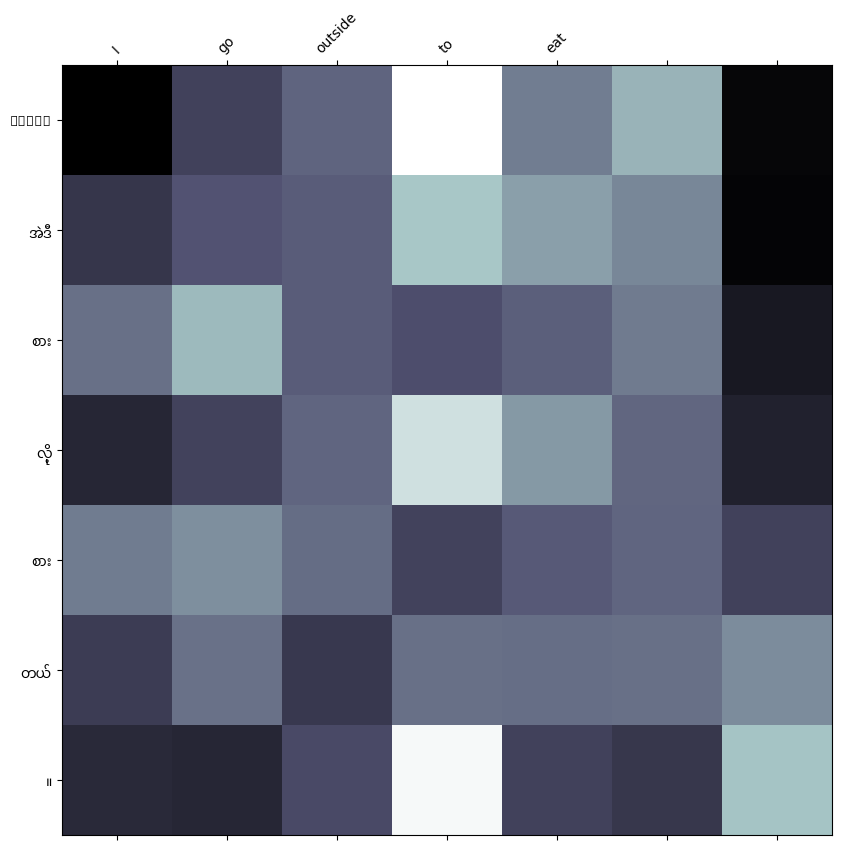

In [46]:
display_attention(english_sentence_3, myanmar_sentence_3_gen, general_attention_map)

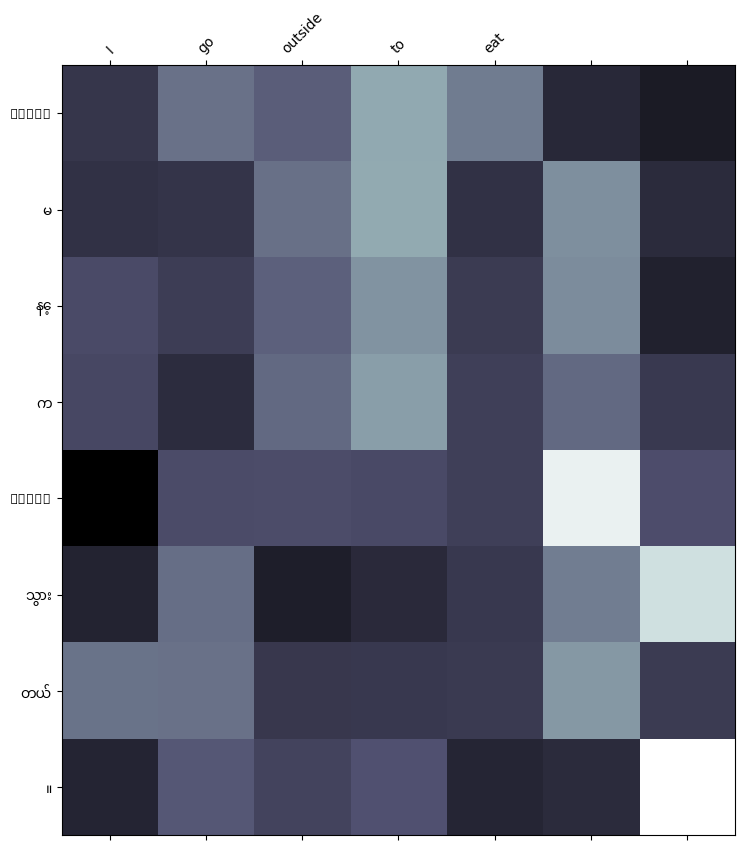

In [47]:
display_attention(english_sentence_3, myanmar_sentence_3_multi, multiplicative_attention_map)

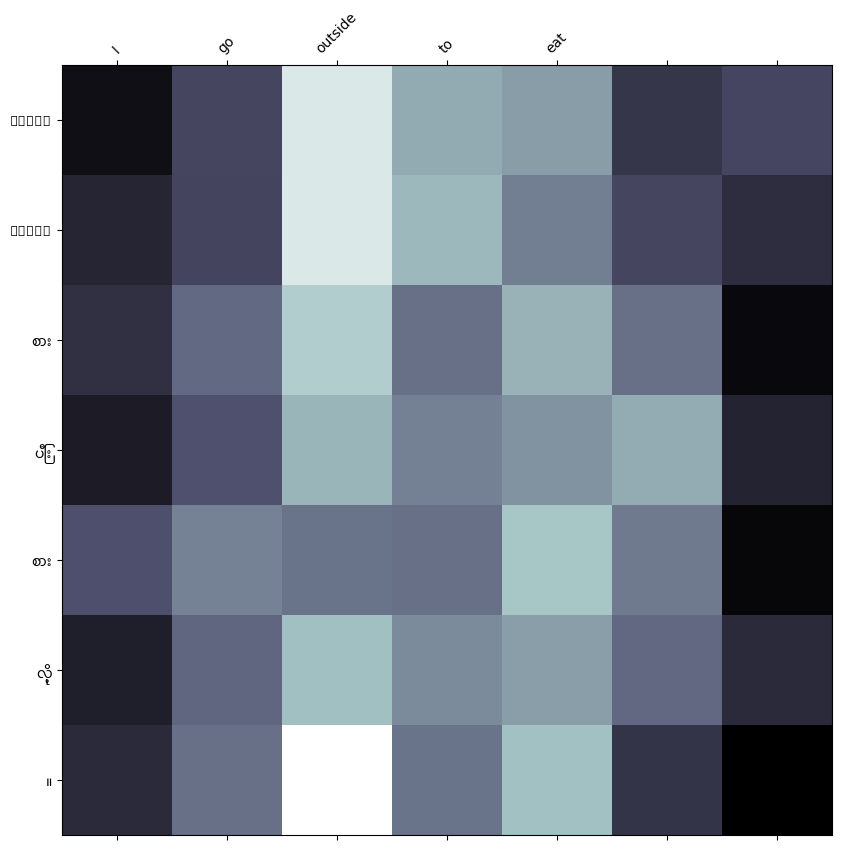

In [48]:
display_attention(english_sentence_3, myanmar_sentence_3_add, additive_attention_map)

### BLEU score

In [51]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(iterator, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for src, trg in iterator:
        
        pred_trg, _ = translate_sentence(src, model, device, max_len)
                
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        #tokenize target sentence so it can be compared with pred_trgs
        trg = token_transform[TRG_LANGUAGE](trg.rstrip("\n"))

        pred_trgs.append(pred_trg)
        trgs.append([trg])

    return bleu_score(pred_trgs, trgs)

In [52]:
# test_iter = (en_my_corpus['test']), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))
# bleu_score = calculate_bleu(test_iter, generalTransformer, device)

# print(f'BLEU score = {bleu_score*100:.2f}')